In [ ]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
APP_DIR = os.path.dirname(os.path.realpath('__file__'))
base_dir = os.path.dirname(APP_DIR)
windows_size = 48
n_features = 3
n_step_out = 3
model_path = f'{base_dir}/data/hotel_call_predict.h5'
scaler_path = f'{base_dir}/data/hotel_call_scaler.npy'

In [ ]:
#import datetime
#def parse(x):
#    arr = x.split(' ')
#    hour = str(int(int(arr[-1])/60))
#    min = str(int(arr[-1])%60)
#    arr[-1] = hour
#    arr.append(min)
#    time = ' '.join(arr)
#    return datetime.datetime.strptime(time, '%Y %m %d %H %M')
#path = f'{base_dir}//data//hotel_call_test.csv'
#df = pd.read_csv(path, parse_dates = [['Date', 'Month','Day','Time']], index_col=0, date_parser=parse)
#df.index.name = 'date_time'
#df = df.sort_values('date_time')
#df = df.loc[:, ['ProductRate','AHT', 'TotalCount']]
#df.to_csv(f'{base_dir}//data//hotel_call_datetime_test.csv')
#df

In [ ]:
# show data trend
def getPlotData():
    path = f'{base_dir}//data//hotel_call_datetime.csv'
    df = pd.read_csv(path)
    X = list()
    Y = list()
    for row_index, row in df.iterrows():
        if(row_index > 48*30):
            break
        try:
            x = str(row[0])
            y = row[3]
            X.append(x)
            Y.append(y)
        except Exception as ex:
            print("error row ,index:" , row_index)
    return X,Y 
x,y = getPlotData()
plt.plot(x,y)
plt.show()

In [ ]:
def loadData(filepath):
    frame = []
    for file in filepath:
        path = f'{base_dir}//data//{file}'
        frame.append(pd.read_csv(path,index_col=0))
    df = pd.concat(frame)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df)
    data_size = len(scaled)
    X = list()
    Y = list()
    for i in range(data_size - windows_size - n_step_out):
        end = i + windows_size
        X.append(scaled[i:end, :])
        Y.append(scaled[end:end + n_step_out,-1].reshape(3))
    # 保存归一化参数
    np.save(scaler_path,scaler)
    return np.array(X), np.array(Y),df

In [ ]:
print("prepare data...")
X, Y,df = loadData(["hotel_call_datetime.csv","hotel_call_datetime_test.csv"])
print(X.shape,Y.shape)
train_size = int(len(X)*0.8)
train_x = X[0:train_size,:,:]
train_y = Y[0:train_size,:]
test_x = X[train_size:-1,:,:]
test_y = Y[train_size:-1,:]
print(train_x.shape,test_x.shape)
print(train_y.shape,test_y.shape)
#train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2)
print("prepare data complete.")
df

In [15]:
def getModel():
    print("create model...")
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True,
                   input_shape=(windows_size, n_features),dropout=0.2))
    model.add(LSTM(100, activation='relu',dropout=0.2))
    model.add(Dense(n_step_out))
    model.compile(optimizer='adam', loss='mse')
    print("create model complete.")
    return model

In [16]:
print("strat training...")
time_start = time.time()
model = getModel()
print("train_x.shape",train_x.shape,"train_y.shape",train_y.shape)
print("test_x.shape",test_x.shape,"test_y.shape",test_y.shape)
print("windows_size:",windows_size)
print("n_features",n_features)
# fit model
history = model.fit(train_x, train_y, epochs=50, batch_size=50,validation_data=(test_x, test_y))
time_end = time.time()
print("save model，path:" ,model_path)
model.save(model_path)
print("train success,cost:", time_end-time_start)

strat training...
create model...
create model complete.
train_x.shape (13168, 48, 3) train_y.shape (13168, 3)
test_x.shape (3291, 48, 3) test_y.shape (3291, 3)
windows_size: 48
n_features 3
Epoch 1/50
264/264 [==============================] - 16s 60ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 2/50
264/264 [==============================] - 16s 62ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/50
264/264 [==============================] - 16s 61ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/50
264/264 [==============================] - 16s 61ms/step - loss: 0.0019 - val_loss: 9.5188e-04
Epoch 5/50
264/264 [==============================] - 16s 61ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 6/50
264/264 [==============================] - 16s 59ms/step - loss: 8.7193e-04 - val_loss: 0.0011
Epoch 7/50
264/264 [==============================] - 16s 59ms/step - loss: 7.3602e-04 - val_loss: 0.0012
Epoch 8/50
264/264 [==============================] - 16s 61ms/step - loss: 7.2896e

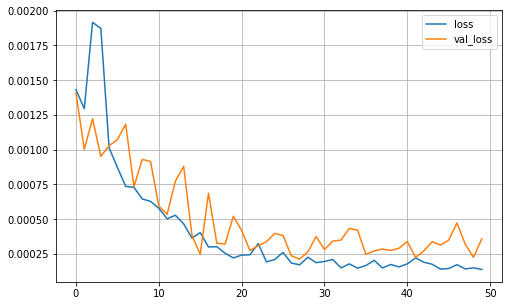

In [17]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True) #打印网格
    #plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [ ]:
#print("evaluate model...")
#result = model.evaluate(test_x, test_y)
#print('result', result)
#print("evaluate model complete.")

In [18]:
train_scaler = np.load(scaler_path,allow_pickle=True).take(0)
train_scaler

MinMaxScaler()

In [19]:
train_model = load_model(model_path)
#load 归一化参数
intput = test_x[0].reshape((1, windows_size, n_features))
yhat = train_model.predict(intput, verbose=0)
left = np.random.random((3,2))
yhat = np.hstack((left,yhat.reshape(3,1)))
yhat = train_scaler.inverse_transform(yhat)
test_y_0 = train_scaler.inverse_transform(np.hstack((left,test_y[0].reshape(3,1))))
print("predict:", yhat[:,-1].reshape(3))
print("real", test_y_0[:,-1].reshape(3))

predict: [ 91.8688551  128.40054016 158.30969644]
real [ 88. 159. 189.]


In [ ]:
predict = []
real = []
left = np.random.random((3,2))
for i in range(len(test_x)):
    if(i > 48*10):
        break
    index = -(i+1)
    #real = df[index -2-2:index-2+1]
    #print("index:",index,",real:",real)
    intput = test_x[index].reshape((1, windows_size, n_features))
    yhat = train_model.predict(intput, verbose=0)
    yhat = np.hstack((left,yhat.reshape(3,1)))
    yhat = train_scaler.inverse_transform(yhat)

    test_y_i = train_scaler.inverse_transform(np.hstack((left,test_y[index].reshape(3,1))))
    predict.append(yhat[:,-1])
    real.append(test_y_i[:,-1])
    #print("predict:", yhat[:,-1],",real:",test_y_i[:,-1])

plt.plot(predict)
plt.plot(real)
plt.legend(['predict1','predict2','predict2', 'real1','real2','real2'])
plt.show()